In [41]:
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import random
import torch
import torch.nn as nn
from copy import deepcopy
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
#for word2vec:
#https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb
#for transD:
#https://github.com/jimmywangheng/knowledge_representation_pytorch/
#for RNN:
# https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

def oneHot(word_idx,vocabulary_size):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

## word2vec encodes entity 
## transE encodes entity and relation
## RNN ecodes entity and order

# word2vec

In [621]:
# parameters and data
vocabulary_size = 10
embedding_dims = 2
sample_size = 10000
pairs=list(zip(range(9),range(1,10)))+[(9,0)]+list(zip(range(10),range(10)))
#pairs=list(zip(range(9),range(1,10)))
#pairs=list(zip(range(9),range(1,10)))+list(zip(range(10),range(10)))
idx_pairs=np.array(random.choices(pairs,k=sample_size))
idx_pairs = np.apply_along_axis(np.random.permutation,1,idx_pairs)

In [623]:
# model and training

W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(),
               requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(),
               requires_grad=True)
#W1 = Variable(W1_data.t(),
#              requires_grad=True)
#W2 = Variable(W1_data,
#              requires_grad=True)

num_epochs = 10
learning_rate = 0.01
Loss=[]
for epo in range(num_epochs):
    loss_val = 0
    for context, target in idx_pairs:
        x = Variable(oneHot(context,vocabulary_size)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)
        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 2 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')
    Loss.append(loss_val/len(idx_pairs))

Loss at epo 0: 1.6194731623530387
Loss at epo 2: 1.1070541038155555
Loss at epo 4: 1.1063459806919098
Loss at epo 6: 1.106031321334839
Loss at epo 8: 1.105803294992447


Text(0,0.5,'Loss')

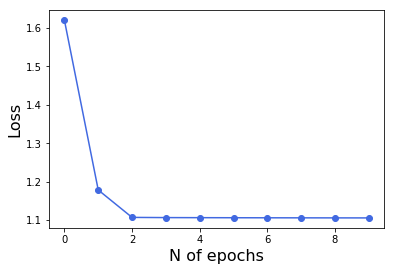

In [624]:
plt.plot(Loss,color='RoyalBlue',marker='o')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

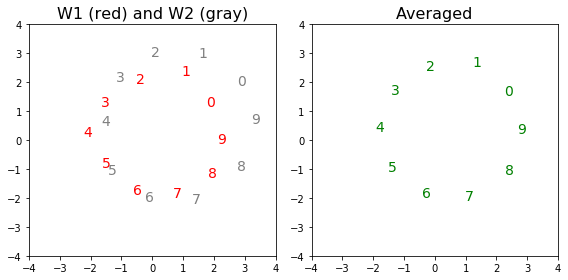

In [627]:
pos1=dict(zip(range(10),W1.data.numpy().T))
pos2=dict(zip(range(10),W2.data.numpy()))
#
fig = plt.figure(figsize=(8, 4),facecolor='white')
ax = fig.add_subplot(121)
for i in pos1:
    x,y=pos1[i]
    #plt.plot(x,y,marker='o',color='r')
    plt.text(x,y,i,size=14,color='r')
#
for i in pos2:
    x,y=pos2[i]
    #plt.plot(x,y,marker='^',color='gray')
    plt.text(x,y,i,size=14,color='gray')
#plt.legend(loc=3)
l=4
plt.xlim(-l,l)
plt.ylim(-l,l)
#annotation
#plt.plot(0,0,'ro')
#plt.text(0,0.5,'center vector (W1)',ha='center',color='r')
#plt.plot(0,0,marker='^',color='gray')
#plt.text(0,-0.5,'context vector (W2)',ha='center',color='gray')
plt.title('W1 (red) and W2 (gray)',fontsize=16)
#
ax = fig.add_subplot(122)
for i in pos1:
    x1,y1=pos1[i]
    x2,y2=pos2[i]
    #plt.plot((x1+x2)/2,(y1+y2)/2,marker='s',color='green')
    plt.text((x1+x2)/2,(y1+y2)/2,i,size=14,color='green')

plt.xlim(-l,l)
plt.ylim(-l,l)
plt.title('Averaged',fontsize=16)
#
plt.tight_layout()
plt.show()

# TransE

In [55]:
def marginLoss(pos, neg, margin):
    return torch.sum(torch.max(pos - neg + margin, torch.zeros(pos.size())))

def getBatchList(tripleList, num_batches):
    l = len(tripleList) // num_batches # batch_size
    v = []
    for i in range(num_batches-1):
        v.append(tripleList[l*i:l*(i+1)])
    v.append(tripleList[l*(num_batches-1):])
    return v

def getBatch_raw_all(tripleList):
    ph, pt ,pr = np.array(tripleList).T
    k=int(len(tripleList)/2)
    newTripleList=deepcopy(tripleList)
    np.random.shuffle(newTripleList[:k,0])# corrupt head/tail for half of data
    np.random.shuffle(newTripleList[k:,-1])
    nh, nt, nr = np.array(newTripleList).T
    return ph, pt, pr, nh, nt, nr

In [57]:
class transE(nn.Module):

    def __init__(self, entity_total, relation_total, embedding_size):
        super(transE, self).__init__()
        
        self.eE = nn.Embedding(entity_total, embedding_size) #embed entities
        self.rE = nn.Embedding(relation_total, embedding_size) #embed relation(s)

    def forward(self, pos_h, pos_t, pos_r, neg_h, neg_t, neg_r):
        
        pos_h_e = self.eE(pos_h)
        pos_t_e = self.eE(pos_t)
        pos_r_e = self.rE(pos_r)
        neg_h_e = self.eE(neg_h)
        neg_t_e = self.eE(neg_t)
        neg_r_e = self.rE(neg_r)
        
        pos = torch.sum((pos_h_e + pos_r_e - pos_t_e) ** 2, 1)
        neg = torch.sum((neg_h_e + neg_r_e - neg_t_e) ** 2, 1)
        return pos, neg
    
    def get_eE(self, inputs):
        return self.eE(inputs)

    def get_rE(self, inputs):
        return self.rE(inputs)
    

In [66]:
# parameters
num_batches=100
embedding_size=2
entity_total=10
relation_total=1
sample_size = 10000
triplets=list(zip(range(9),[0]*10,range(1,10)))
trainList=np.array(random.choices(triplets,k=sample_size))
trainBatchList = getBatchList(trainList, num_batches)
model = transE(entity_total, relation_total, embedding_size)
optimizer = optim.SGD(model.parameters(), lr=0.01) 

In [68]:
triplets

[(0, 0, 1),
 (1, 0, 2),
 (2, 0, 3),
 (3, 0, 4),
 (4, 0, 5),
 (5, 0, 6),
 (6, 0, 7),
 (7, 0, 8),
 (8, 0, 9)]

In [63]:
# model and training
num_epochs = 30
Loss=[]
for epo in range(num_epochs):
    loss_val = 0
    random.shuffle(trainBatchList)
    for batchList in trainBatchList:
        #
        optimizer.zero_grad()
        #
        pos_h_batch, pos_r_batch, pos_t_batch,  neg_h_batch, neg_r_batch , neg_t_batch\
        = getBatch_raw_all(batchList)
        pos_h_batch = Variable(torch.LongTensor(pos_h_batch))
        pos_t_batch = Variable(torch.LongTensor(pos_t_batch))
        pos_r_batch = Variable(torch.LongTensor(pos_r_batch))
        neg_h_batch = Variable(torch.LongTensor(neg_h_batch))
        neg_t_batch = Variable(torch.LongTensor(neg_t_batch))
        neg_r_batch = Variable(torch.LongTensor(neg_r_batch))
        pos, neg = model(pos_h_batch, pos_t_batch, pos_r_batch,\
                         neg_h_batch, neg_t_batch, neg_r_batch)
        losses = marginLoss(pos, neg, 1)        
        loss_val += losses.item()
        losses.backward()
        optimizer.step()
        
    
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(batchList)}')
    Loss.append(loss_val/len(batchList))        

Loss at epo 0: 18.407009253501894
Loss at epo 10: 13.17
Loss at epo 20: 12.2


Text(0,0.5,'Loss')

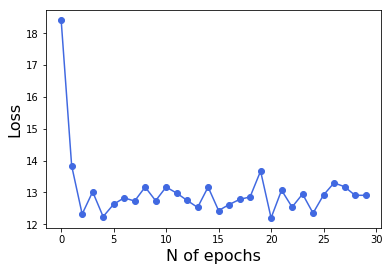

In [64]:
plt.plot(Loss,color='RoyalBlue',marker='o')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

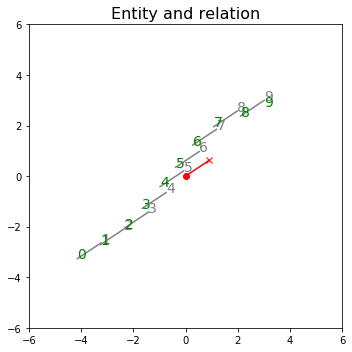

In [65]:
posR=dict(zip(range(10),model.get_rE(Variable(torch.LongTensor([0]))).data.numpy()))
posE=dict(zip(range(10),model.get_eE(Variable(torch.LongTensor(range(10)))).data.numpy()))
#
fig = plt.figure(figsize=(5, 5),facecolor='white')
ax = fig.add_subplot(111)
plt.title('Entity and relation',fontsize=16)
#
x,y=posR[0]
plt.plot(0,0,'ro')
plt.plot(x,y,'rx')
plt.plot([0,x],[0,y],'r-')
#
for i in range(9):
    x,y=posE[i]
    x_new,y_new=posE[i]+posR[0]
    plt.text(x,y,i,size=14,color='green')
    plt.text(x_new,y_new,i+1,size=14,color='gray')
    plt.plot([x,x_new],[y,y_new],color='gray')
    
x,y=posE[9]
plt.text(x,y,9,size=14,color='green')
#
l=6
plt.xlim(-l,l)
plt.ylim(-l,l)
#
#
plt.tight_layout()
plt.show()

# RNN

In [160]:
class RNN(nn.Module):

    def __init__(self, entity_total, embedding_size):
        super(RNN, self).__init__()
        self.embedding_size = embedding_size
        self.W_h = nn.Linear(embedding_size, embedding_size)
        #self.input_embedding = nn.Embedding(entity_total, embedding_size) input matrix != output matrix
        #self.output_embedding = nn.Linear(embedding_size, entity_total)
        self.input_embedding = nn.Linear(entity_total, embedding_size)
        self.output_embedding =  nn.Linear(embedding_size,entity_total)
        self.output_embedding.weight.data = self.input_embedding.weight.data.transpose(0,1)
        self.softmax = nn.LogSoftmax(dim=2)
        
    #def embed(self,item):
    #    return self.input_embedding(item)
    def embed(self,oneHot):
        return self.input_embedding(oneHot)
        
    #def forward(self, item, legacy):
    #    legacy_ = self.W_h(legacy) + self.input_embedding(item)
    #    return legacy_
    
    def forward(self, oneHot, legacy):
        legacy_ = self.W_h(legacy) + self.input_embedding(oneHot)
        return legacy_
    
    def predict(self,legacy):
        return self.softmax(self.output_embedding(legacy))
    
    def initLegacy(self):
        return torch.zeros(1, 1, self.embedding_size)
    

In [178]:
triplets=list(zip(range(8),range(1,9),range(2,10)))
entity_total=10
embedding_size=2
rnn=RNN(entity_total, embedding_size)
legacy=rnn.initLegacy()
learning_rate = 0.02
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# trainning

Loss=[]
for epoch in range(160):
    l=0
    for items in triplets:
        loss=0
        optimizer.zero_grad()
        inputs = items[:2]
        target = Variable(torch.LongTensor([items[-1]])) 
        # forward
        for i in inputs:
            #item=Variable(torch.LongTensor([i]))
            #legacy=rnn.forward(item,legacy)
            onehot=oneHot(i,entity_total)
            legacy=rnn.forward(onehot,legacy)
        prediction=rnn.predict(legacy) 
        loss=criterion(prediction[0],target)
        # backward
        loss.backward(retain_graph=True)
        optimizer.step()
        l+=loss.item()
    Loss.append(l/len(triplets))
    if epoch%40==0:
        print(epoch, l/len(triplets))

0 2.441704958677292
40 2.08979594707489
80 1.5070112496614456
120 0.9017600864171982


Text(0,0.5,'Loss')

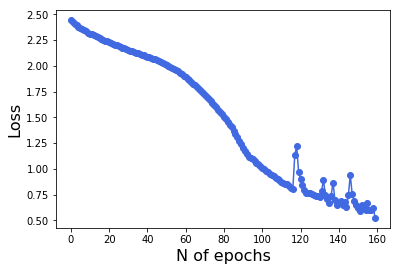

In [179]:
plt.plot(Loss,color='RoyalBlue',marker='o')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

In [180]:
for items in triplets:
    inputs = items[:2]
    target = Variable(torch.LongTensor([items[-1]])) 
    # forward
    for i in inputs:
        #item=Variable(torch.LongTensor([i]))
        #legacy=rnn.forward(item,legacy)
        onehot=oneHot(i,entity_total)
        legacy=rnn.forward(onehot,legacy)
    prediction=rnn.predict(legacy) 
    print(inputs,target.item(),np.argmax(prediction.data.numpy()))

(0, 1) 2 2
(1, 2) 3 3
(2, 3) 4 4
(3, 4) 5 5
(4, 5) 6 6
(5, 6) 7 8
(6, 7) 8 8
(7, 8) 9 2


In [181]:
posE=dict(zip(range(10),rnn.input_embedding.weight.data.numpy().T))
posE_=dict(zip(range(10),rnn.output_embedding.weight.data.numpy()))
W_h=rnn.W_h.weight.data.numpy()

(-3, 3)

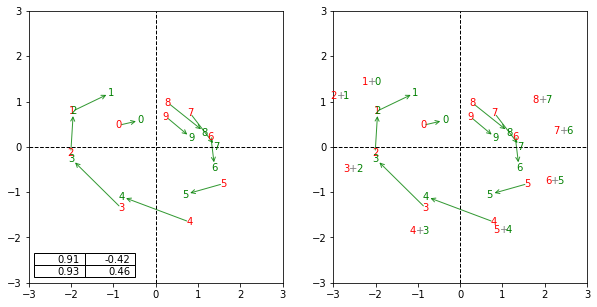

In [211]:

l=3
fig = plt.figure(figsize=(10, 5),facecolor='white')

ax = fig.add_subplot(121)
for i in range(10):
    xi,yi=posE[i]
    xi_,yi_=np.matmul(posE[i],W_h)
    plt.text(xi,yi,str(i),color='r',ha='center',va='center')
    plt.text(xi_,yi_,str(i),color='g',ha='center',va='center')
    #plt.plot([xi,xi_],[yi,yi_],linestyle='-',linewidth=.5,color='green')
    ax.annotate("",
                xy=(xi, yi), xycoords='data',
                xytext=(xi_, yi_), textcoords='data',
                arrowprops=dict(arrowstyle="<-", #linestyle="dashed",
                                color="green",
                                alpha=.8,
                                shrinkA=5, shrinkB=3,
                                patchA=None,
                                patchB=None
                                ),zorder=1
                )
    
ax.table(cellText=np.round(W_h,2),loc='lower left',colWidths=[.2,.2])
#plt.text(-6.5,-7,'W_h')
plt.plot([-l,l],[0,0],'k--',linewidth=1)
plt.plot([0,0],[-l,l],'k--',linewidth=1)
plt.xlim(-l,l)
plt.ylim(-l,l)


ax = fig.add_subplot(122)

for i in range(10):
    xi,yi=posE[i]
    xi_,yi_=np.matmul(posE[i],W_h)
    plt.text(xi,yi,str(i),color='r',ha='center',va='center')
    plt.text(xi_,yi_,str(i),color='g',ha='center',va='center')
    #plt.plot([xi,xi_],[yi,yi_],linestyle='-',linewidth=.5,color='green')
    ax.annotate("",
                xy=(xi, yi), xycoords='data',
                xytext=(xi_, yi_), textcoords='data',
                arrowprops=dict(arrowstyle="<-", #linestyle="dashed",
                                color="green",
                                alpha=.8,
                                shrinkA=5, shrinkB=3,
                                patchA=None,
                                patchB=None
                                ),zorder=1
                )
    
    
for items in triplets:
    a,b,c=items
    xc_p,yc_p=np.matmul(posE[a],W_h)+posE[b]
    #plt.text(xb,yb,str(b),color='r')
    #plt.text(xa_,ya_,str(a)+'',color='g')
    plt.text(xc_p,yc_p, str(b),color='r')
    plt.text(xc_p+l/20,yc_p, '+',color='gray')
    plt.text(xc_p+l/10,yc_p, str(a),color='g')
    
plt.plot([-l,l],[0,0],'k--',linewidth=1)
plt.plot([0,0],[-l,l],'k--',linewidth=1)
    
plt.xlim(-l,l)
plt.ylim(-l,l)